In [1]:
from loveisland.src.topic_model_1 import import_data
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import os

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pyLDAvis.sklearn
import datetime as dt 

from loveisland.common.constants import ISLANDERS
from loveisland.common.functions import get_palette, get_islander_df

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [2]:
# PALETTE = get_palette()

# islander_df = get_islander_df()
# RELEVANT_ISLANDERS = islander_df[
#     (islander_df["arrived"] <= 35)
#     & ((islander_df["dumped"] >= 21) | (islander_df["dumped"] == 0))
# ]["islander"]

In [3]:
def fmt_dt(d):
    return dt.datetime.strptime(d, "%Y-%m-%d")


def get_dates(start_date="2019-06-24", end_date="2019-07-08"):
    start_date = fmt_dt(start_date)
    delta = fmt_dt(end_date) - start_date
    return [
        str((start_date + dt.timedelta(days=i)).date()) for i in range(delta.days + 1)
    ]

In [4]:
dates = get_dates()

In [5]:
storyline = {
    " Third Recoupling \n Yewande Dumped": {"date": "2019-06-24", "color": "Red", "h": 1, "t": 10, "d": 22},
    " Arabella and Tom \n are Dumped": {"date": "2019-06-27", "color": "Red", "h": 1, "t": 3, "d": 25},
    " Casa Amor Begins": {"date": "2019-06-28", "color": "Green", "h": 2, "t": 7, "d": 26},
    " Fourth Recoupling \n Dan, Dennon, Stevie \n Lavena, Maria and Nabila dumped": 
    {"date": "2019-07-02", "color": "Green", "h": 2, "t": 3, "d": 30},
}
for_tl = pd.DataFrame({"date": dates, "filler": 1})

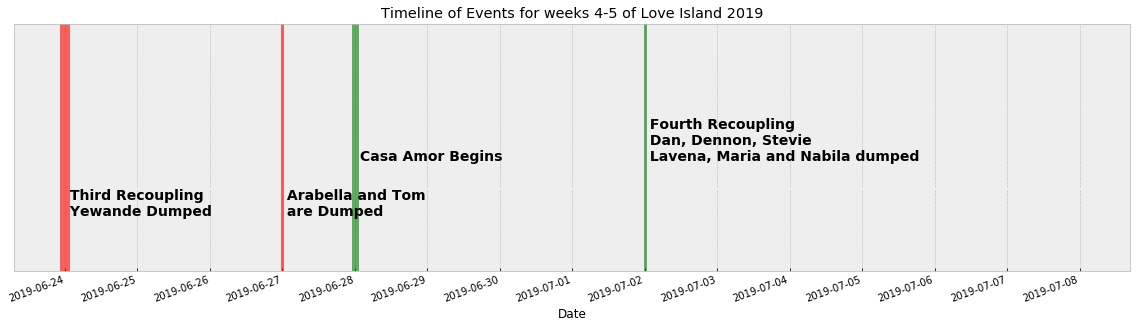

In [6]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)

sns.lineplot(x="date", y="filler", color="#EEEEEE", data=for_tl, ax=ax1)
plt.xticks(rotation=20, ha="right")
ax1.set(xticks=for_tl.date.unique(), yticks=[], xlabel="Date", ylabel="", ylim=(0, 3))
plt.title("Timeline of Events for weeks 4-5 of Love Island 2019")

for key, item in storyline.items():
    ax1.axvline(item["date"], color=item["color"], linewidth=item["t"], alpha=0.6)
    ax1.text(item["date"], 2 * item["h"] / 3, key, fontsize=14, weight="bold")


In [7]:
class Arguments():
    bucket = "../data/"
    
args = Arguments()

In [8]:
def import_aspects(args, dt):
    """Import model"""
    path = os.path.join(args.bucket, "{}", str(dt) + ".pkl")
    return (
        pickle.load(open(path.format("models"), "rb")),
        pickle.load(open(path.format("vocab"), "rb")),
    )


def get_terms(mod, feature_names, n_words, print_terms=True):
    for_df = []
    for topic_idx, topic in enumerate(mod.components_):
        terms = [feature_names[i] for i in topic.argsort()[: -(n_words + 1) : -1]]
        for_df.append({"topic": topic_idx, "terms": terms})
        if print_terms:
            print("Topic", topic_idx, ":", terms)
    return pd.DataFrame(for_df)


def setup_aspects(args, date, col="processed_text"):
    df = import_data(args, date)
    mod, vocab = import_aspects(args, date)

    vectorizer = CountVectorizer(vocabulary=vocab)
    vectorizer._validate_vocabulary()
    A = vectorizer.fit_transform(df[col])
    return mod, vectorizer, A, vectorizer.get_feature_names()


def get_visual(args, date, mod, A, vectorizer):
    pyLDAvis.enable_notebook()
    p = pyLDAvis.sklearn.prepare(mod, A, vectorizer)
    pyLDAvis.save_html(p, os.path.join(args.bucket, "pylda_htmls", date + ".html"))
    return p


def convert_to_df(to_plot, start_date="2019-06-24", end_date="2019-07-08"):
    to_plot = pd.DataFrame.from_dict(to_plot, orient="index")
    to_plot.index.name = "date"
    to_plot = to_plot.reset_index()
    to_plot["date"] = pd.to_datetime(to_plot["date"])
    return to_plot[(start_date <= to_plot["date"]) & (to_plot["date"] <= end_date)]


def n_tweets(args, date):
    df = pd.read_csv(
        os.path.join(args.bucket, "processed", date + ".csv"), low_memory=False
    )
    return len(df)


def topic_probs(doc_tops, df):
    for_df = []
    for i in range(len(doc_tops)):
        js = {}
        for j in range(len(doc_tops[i])):
            js[str(j)] = float(doc_tops[i][j])
        js["processed_text"] = df["processed_text"][i]
        for_df.append(js)
    return pd.DataFrame(for_df)


def top_topic(df):
    df = pd.melt(df, id_vars=['processed_text'], var_name='topic')
    df["val_max"] = df.groupby(['processed_text'])['value'].transform(max)
    return df[df["value"] == df["val_max"]]\
            .drop(columns="val_max")\
            .reset_index(drop=True)

In [215]:
to_plot = pickle.load(open(args.bucket + "best_param.pkl", "rb"))

for date in dates:
    mod, vectorizer, A, bag_of_words = setup_aspects(args, date)
    
    # get_visual(args, date, mod, A, vectorizer)

    to_plot = pickle.load(open(args.bucket + "best_param.pkl", "rb"))

    for date in dates:
        mod, vectorizer, A, bag_of_words = setup_aspects(args, date)
        to_plot[date]["perplexity"] = mod.perplexity(A)
        to_plot[date]["n_tweets"] = n_tweets(args, date)

to_plot = convert_to_df(to_plot)

KeyboardInterrupt: 

LDA learning decay is the rate at which old information / weights are forgotten per iteration, ie how much weight does a topic hold after it has been created in relation to a potential new topic. 

file:///Users/samwatson/Downloads/Online_Learning_for_Latent_Dirichlet_Allocation.pdf

One could argue that their is a negative correlation between the number of tweets contained in the corpus and the learning decay (ie the greater the total tweets, the lower the learning decay). This isn't a hugely striking relationship however it does make sense as one would expect a larger range of topics in a larger corpus, especially given the multi-faceted nature of the show and the fact that there are lots of differing story lines per episode that are likely to result in a significant number of tweets each. On the day we saw the most tweets (7th July - the recoupling / ending of Casa Amor), there were 3 of the biggest stories of the show coming to a point (both Anna and Micheal recoupling with new islanders and leaving their original partner single as well as the controversy / drama surrounding Amy and Curtis' relationship). Given this to this one would imagine that the model needed to be more dynamic in changing the weighing of topics and therefore required a lower learning decay than the models performed on tweets from Saturdays when the show is not and and not a lot is spoken about online.  

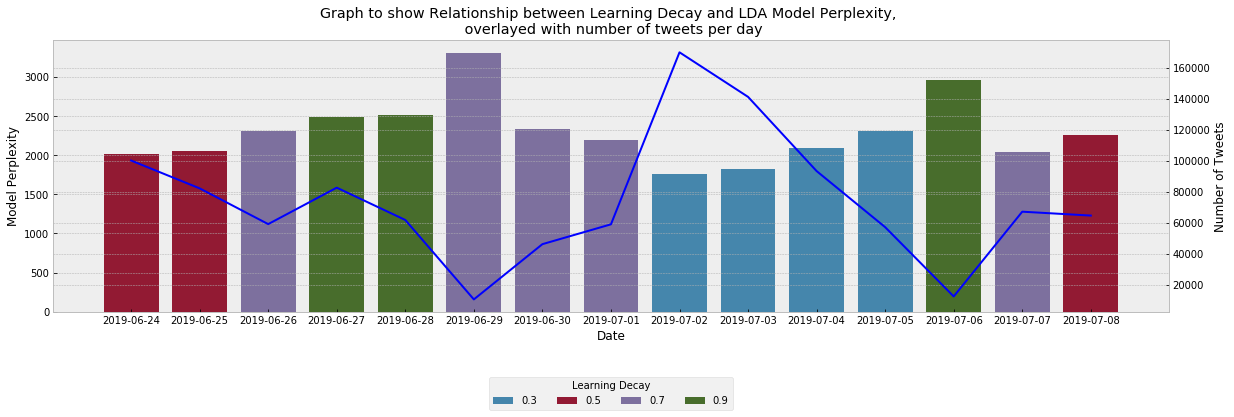

In [10]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

to_plot["date"] = to_plot["date"].astype(str)

sns.barplot("date", "perplexity", "learning_decay", data=to_plot, dodge=False, ax=ax1)
ax1.set(
    xlabel="Date",
    ylabel="Model Perplexity",
    title="Graph to show Relationship between Learning Decay and LDA Model Perplexity, \n "
          "overlayed with number of tweets per day",
)

sns.lineplot(x="date", y="n_tweets", color="Blue", data=to_plot, ax=ax2)
ax2.set_ylabel("Number of Tweets")

plt.xticks(rotation=20, ha="right")
ax1.legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=5, title="Learning Decay")


In [9]:
date = "2019-07-02"

mod, vectorizer, A, bag_of_words = setup_aspects(args, date)
df = import_data(args, date)

doc_tops = mod.transform(A)
top_df = topic_probs(doc_tops, df)
top_df = top_topic(top_df)

df = df.merge(top_df, on="processed_text", how="left")

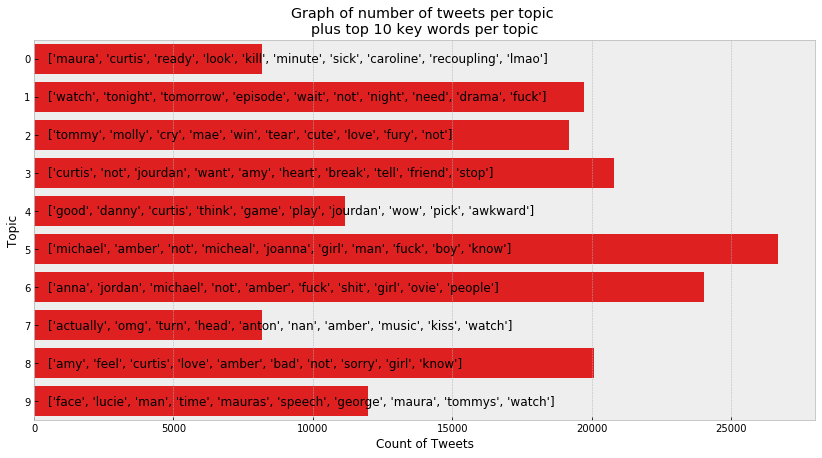

In [10]:
def plot_top(df, mod, bag_of_words):
    fig = plt.figure(figsize=(14, 7))
    df = df.groupby("topic")["value"].count().reset_index(name="count")
    df["topic"] = df["topic"].astype(int)
    
    terms = get_terms(mod, bag_of_words, 10, False)
    df = df.merge(terms, on="topic", how="left")
    
    ax1 = fig.add_subplot(111)
    sns.barplot(x="count", y="topic", data=df, color='Red', ax=ax1, orient="h")
    
    for i, row in df.iterrows():
        ax1.annotate(row["terms"], xy=(0,0), xytext=(500, i+0.1), color="Black", fontsize=12)
        
    ax1.set(ylabel="Topic", xlabel="Count of Tweets", title="Graph of number of tweets per topic \nplus top 10 key words per topic")
    
plot_top(top_df, mod, bag_of_words)

Top tweet per topic based on the probability of the tweet being in each topic. Probability is the likelihood of the tweet being in each topic, therefore each tweet has a probability per topic with these summing to one. As we can see, when we pick the tweet with the highest probability of being in each topic they seem fairly random given the corpus, we know the the algorithm finds the probability on a word by word basis, therefore the more key words per topic a text has the more likely it is to be in that topic. We also know that the probability is based on likelihood of being in each topic in comparison to each of the other topics, therefore if a tweet has a keyword from topic 0 and no words match any key words from any other topics, the algorithm places a very high probability of this tweet being in this topic even though it is seemingly very random. 


In light of this, to address the fact that this isnt that useful in the real world, we can filter out tweets with less than a 60% probability of being related with a topic and then pull out the most popular in terms of favourites on twitter, we would expect this tweet to not only be about love island and therefore would have to have a lot of key words to be assigned such a high probability but also be very relevant to the topic itself due to recieving a lot of likes. 

In [11]:
def top_doc(df):
    df = df.sort_values(by="value", ascending=False)\
        .groupby(["topic"])\
        .head(1)\
        .sort_values(by="topic")\
        .reset_index(drop=True)
    
    print("Top document per topic")
    
    for i, row in df.iterrows():
        print("Topic {0} (probability={1})".format(row["topic"], round(row["value"], 2)), 
              "\nText:", row["text"], "\n")
        
top_doc(df)

Top document per topic
Topic 0 (probability=0.96) 
Text: Worden deelnemers betaald en wie kookt er eigenlijk? Achter de schermen van ‘Love Island’ http://www.nieuwsoverzicht.info/2019/07/worden-deelnemers-betaald-en-wie-kookt-er-eigenlijk-achter-de-schermen-van-love-island/ … 

Topic 1 (probability=0.97) 
Text: Who wants a repeat of summer 2018? 2019 weather is getting warmer, people are talking about Love Island, and we have the World Cup! England Women's World Cup 2019, journey continues to the semi-finals tonight! # WomensWorldCup2019 # driving https://www.telegraph.co.uk/world-cup/2019/07/01/england-womens-world-cup-2019-squad-team-news-semi-final-match/ … via @ Telegraphpic.twitter.com/ryWXPsXE2h 

Topic 2 (probability=0.97) 
Text: # Brexit # Trump # Boris # etsy # etsyfinds # HandmadeHour # handmadegifts # artsandcrafts # TuesdayMorning # LoveIsland # uniquegiftshttps://www.etsy.com/Cathygiftsandthings/listing/615628060/letter-to-santa-coasters-plastic-canvas?utm_source=Copy&utm_

In [16]:
def top_doc(df):
    
    df["trial"] = df["favs"]*df["value"]
    df = df[df["value"] > 0.5]\
        .sort_values(by="favs", ascending=False)\
        .groupby(["topic"])\
        .head(1)\
        .sort_values(by="topic")\
        .reset_index(drop=True)
 
    print("Top document per topic")
    
    for i, row in df.iterrows():
        print("Topic {0} (probability={1})".format(row["topic"], round(row["value"], 2)), 
              "\nText:", row["text"], "\n")
        
top_doc(df)

Top document per topic
Topic 0 (probability=0.82) 
Text: Name a more iconic duo. We'll wait. # LoveIsland pic.twitter.com/64pc1ItNCD 

Topic 1 (probability=0.53) 
Text: Me when I thought shit was about to go down and then seeing the words ‘Tomorrow Night’ # LoveIsland pic.twitter.com/rwY7xhslEX 

Topic 2 (probability=0.64) 
Text: thinking about how molly mae thought tommy had changed his mind about her because ellie belly wasn’t on the bed but in reality he’d been carrying ellie belly round for the last 3 days straight # loveisland pic.twitter.com/dlOdwdnjLx 

Topic 3 (probability=0.89) 
Text: Was Jordan not trying to get to know other girls but failed? Or is it not the same Love Island we were watching? # loveisland https://twitter.com/jackblenkiron/status/1146166029032329217 … 

Topic 4 (probability=0.5) 
Text: Are you deeping Jourdane’s facial expressions? She’s enjoying this episode as much as us boy # LoveIsland 

Topic 5 (probability=0.69) 
Text: Wouldn’t trust Michael the firefi

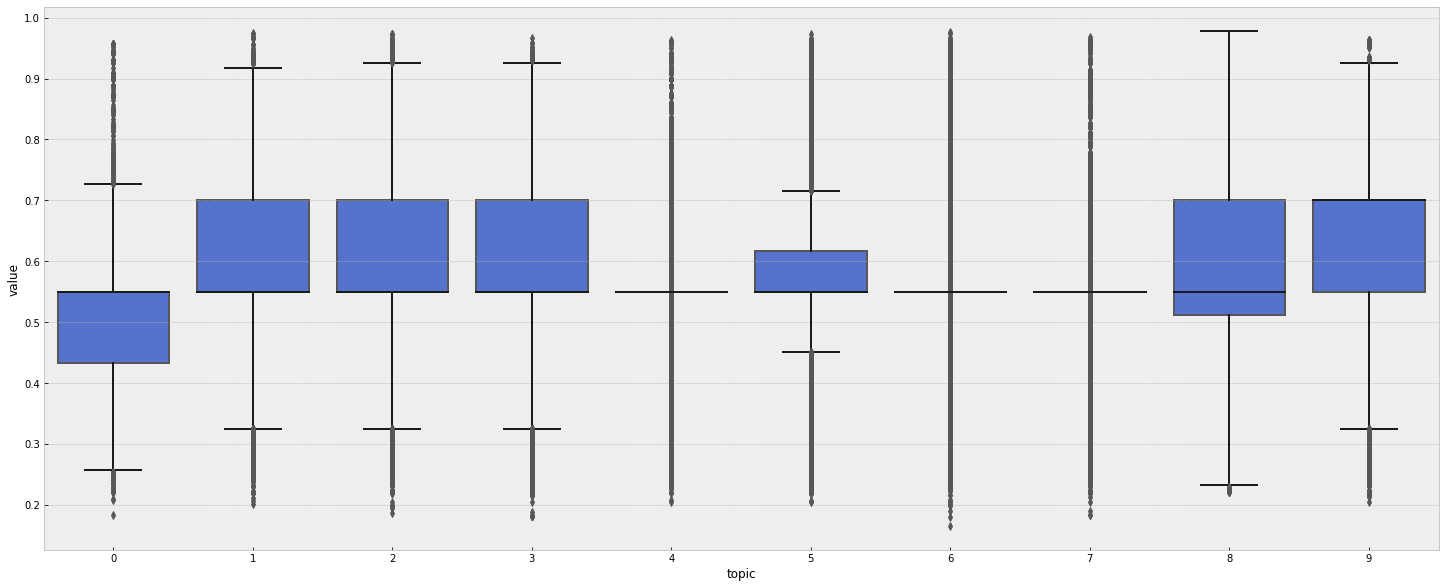

In [223]:
plt.figure(figsize=(25,10))
ax = sns.boxplot(x="topic", y="value", data=df, color="royalblue")
plt.setp(ax.lines, color=".1");

In [ ]:
pn_pal = {"Negative": "Red", "Positive":"Green"}

means = df.groupby("topic")["score"].mean().reset_index(name="topic_mean_senti")
means['col'] = np.where(means["topic_mean_senti"] > 0, "Positive", "Negative")
full = full.merge(df, on="topic", how="left")

plt.figure(figsize=(25,10))
sns.boxplot("topic", "score", hue="col", data=full, 
            dodge=False, palette={"Negative": "Red", "Positive":"Green"})
plt.setp(ax.lines, color=".1");